In [1]:
# Notebook setup
import numpy as np                          # a scientific computing library
from matplotlib import pyplot as plt        # a plotting library
from mpl_toolkits.mplot3d import Axes3D     # necessary for generating 3D plots
plt.rcParams['axes.labelsize'] = 20         # set default plot axes label font size
plt.rcParams['axes.titlesize'] = 24         # set default plot title font size
plt.rcParams['legend.fontsize'] = 18        # set default plot legend font size
# make plots inline in the notebook instead of creating a new window
%matplotlib inline

# Use this function when asked to compute the RMSE
def compute_rmse(x, y):
    """Computes the root mean-square error"""
    assert np.array_equal(x.shape, y.shape), (
        'x %s and y %s shapes do not match. Fix them before using compute_rmse.' % 
        (str(x.shape), str(y.shape)))
    ret = np.sqrt(np.mean((x-y)**2))
    return ret

# 1) Representation
In class, we learn how to encode and decode a signal using a set of nonlinear functions (the firing rates of an ensemble of neurons). Here we will go through the steps of encoding and decoding a 2D signal. 

Recall that the input current to a neuron is given by

$$J=\alpha(\mathbf{e}\cdot\mathbf{x})+J_{bias}$$

where
 - $\alpha$ is a positive constant that scales and converts the projected input into current
 - $\mathbf{e}$ is the unit-length, $d$-dimensional encoding vector
 - $\mathbf{x}$ is the $d$-dimensional input signal 
 - $J_{bias}$ is a bias current

__Do not use code from Nengo for questions in this problem__.

## 1.1) Encoders

### 1.1.1) Generate encoding vectors
Randomly generate 100, 2-dimensional encoding vectors on the unit circle from a uniform distribution. 
 - Make a 2D [scatter](http://matplotlib.org/api/pyplot_api.html?highlight=scatter#matplotlib.pyplot.scatter) plot of the encoding vectors. (Hint: Consider using numpy.random.[randn](http://docs.scipy.org/doc/numpy/reference/routines.random.html) and numpy.linalg.[norm](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html))

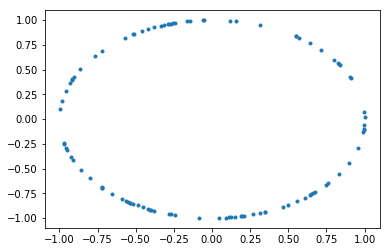

In [38]:
N = 100  # number of encoding vectors and neurons

e = np.random.randn(100,2)
norm = np.sqrt(np.sum(e**2, 1))
norm = np.reshape(norm, (-1, 1))
e /= norm

plt.plot(e[:,0], e[:,1], '.')
plt.show()

### 1.1.2) Convert input signals to input current
Here is a 2D input signal that varies with time.

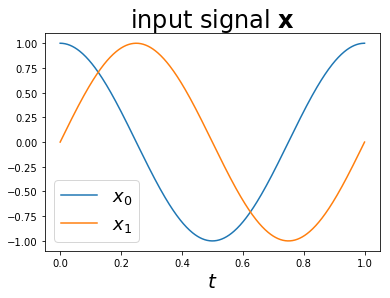

In [39]:
def get_p1_input():
    t = np.linspace(0, 1., 500)
    x = np.array([np.cos(2*np.pi*t), np.sin(2*np.pi*t)]).T
    return t, x

t, x = get_p1_input()
plt.plot(t, x[:,0], label=r'$x_0$')
plt.plot(t, x[:,1], label=r'$x_1$')
plt.legend(loc='lower left')
plt.xlabel(r'$t$')
plt.title('input signal $\mathbf{x}$');

Pick one of the 2D encoding vectors you created in 1.1.1, and use it to convert the input signal $\mathbf{x}$ into an input current $J$. Assume $\alpha=1$ and $J_{bias}=0$. 
 - Print out the vector you used
 - Plot the input current over time.

[-0.71903168 -0.69497729]


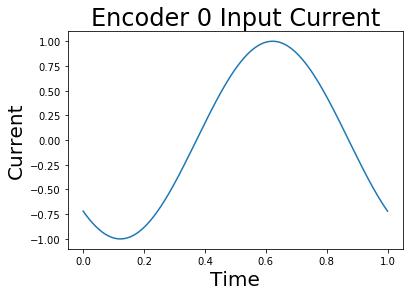

In [47]:
j = x.dot(e[0,:])
print(e[0,:])
plt.figure()
plt.plot(t, j)
plt.xlabel('Time')
plt.ylabel('Current')
plt.title('Encoder 0 Input Current')
plt.show()

## 1.2) Tuning curves

### 1.2.1) Generate tuning curve parameters
Randomly generate $\alpha$ and $J_{bias}$ values from a [uniform](http://docs.scipy.org/doc/numpy/reference/generated/numpy.random.uniform.html) distribution to use with the encoding vectors you generated in 1.1 .

In [73]:
alpha_min = .1  # minimum alpha value
alpha_max = 5.  # maximum alpha value
J_bias_min = -1.  # minimum J_bias value
J_bias_max = 2.   # maximum J_bias value
alpha = np.random.uniform(low=alpha_min, high=alpha_max, size=100)
J_bias = np.random.uniform(low=J_bias_min, high=J_bias_max, size=100)

### 1.2.2) Generate tuning curves
Here is a nonlinear function that describes the firing rate (tuning curve) of a leaky integrate-and-fire (LIF) neuron.

$$
a(J) =
\begin{cases}
\frac{1}{\tau_{ref}-\tau_m\ln(1-\frac{1}{J})} & J > 1 \\
0 & J \le 1
\end{cases}
$$

In [59]:
# Here is a function that computes the neuron firing rate from the input current
tau_m = .005   # membrane time constant
tau_ref = .001 # refractory period
def LIF_fun(J):
    a = np.zeros_like(J)
    idx = J>1.
    a[idx] = 1./(tau_ref - tau_m * np.log(1-1./J[idx]))
    return a

Using the encoding vectors, $\alpha$ values, and $J_{bias}$ values you generated,
 - Plot the tuning curves of three neurons as [3D surface plots](http://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html#mpl_toolkits.mplot3d.Axes3D.plot_surface).

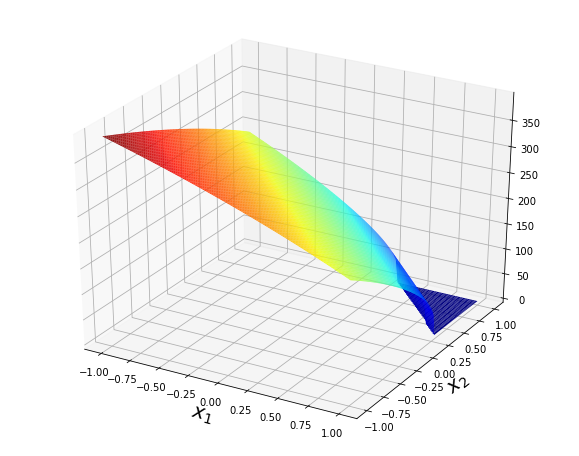

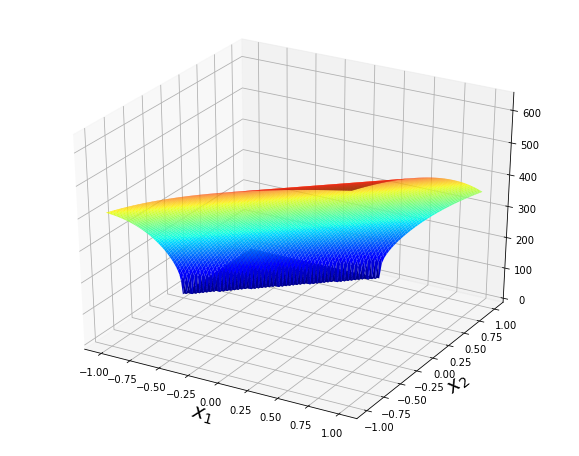

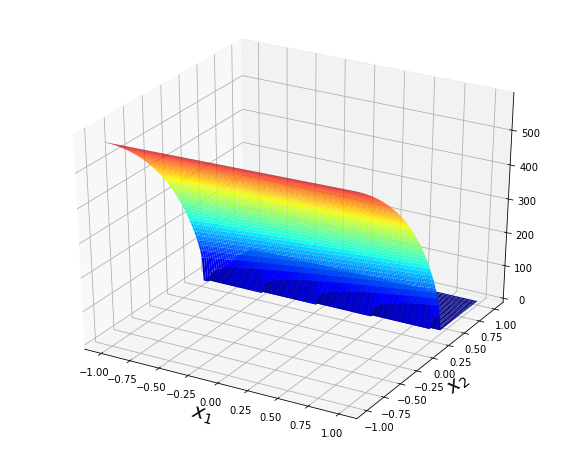

In [74]:
xi = np.linspace(-1, 1, 100)
x0, x1 = np.meshgrid(xi, xi)  # input space over which to plot tuning curve

# Neuron 1 
J0 = alpha[0]*x0*e[0,0]+J_bias[0]
J1 = alpha[0]*x1*e[0,1]+J_bias[0]
J = J0 + J1
A = LIF_fun(J)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1, projection='3d')
p = ax.plot_surface(x0, x1, A,
                    linewidth=0, cstride=1, rstride=1, cmap=plt.cm.jet)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');

# Neuron 2
J0 = alpha[1]*x0*e[1,0]+J_bias[1]
J1 = alpha[1]*x1*e[1,1]+J_bias[1]
J = J0 + J1
A = LIF_fun(J)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1, projection='3d')
p = ax.plot_surface(x0, x1, A,
                    linewidth=0, cstride=1, rstride=1, cmap=plt.cm.jet)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');

# Neuron 1 
J0 = alpha[2]*x0*e[2,0]+J_bias[2]
J1 = alpha[2]*x1*e[2,1]+J_bias[2]
J = J0 + J1
A = LIF_fun(J)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1, projection='3d')
p = ax.plot_surface(x0, x1, A,
                    linewidth=0, cstride=1, rstride=1, cmap=plt.cm.jet)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');

### 1.2.3) Plot tuning curves projected along encoding vector 
It's a bit cumbersome to visualize the tuning curves of neurons with 2D encoding vectors. Visualizing tuning curves is even more difficult in higher dimensions. Instead, we can look at the tuning curves as a function of the input projected onto each neuron's encoding vector (i.e. as a function of the dot product $\mathbf{e}\cdot\mathbf{x}$). 

 - On a single plot, overlay the tuning curves for __all__ of the neurons as a function $\mathbf{e}\cdot\mathbf{x}$.

<function matplotlib.pyplot.show>

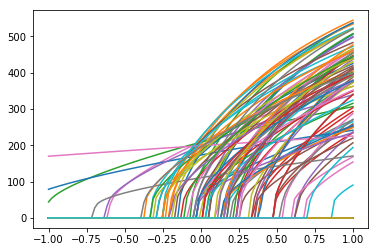

In [115]:
X = np.zeros((e.shape[0],xi.shape[0])) + 1.0
X *= alpha
X = X.T
X *= xi
X = (X.T + J_bias).T
A = LIF_fun(X)

plt.figure()
for i in range(xi.shape[0]):
    plt.plot(xi, A[i,:])
plt.show

### 1.2.4) Compute firing rate over time
 - Plot the neural firing rates over time as a function of the input signal in 1.1.2

In [127]:
rates = LIF_fun(J_bias*x.dot(e.T) + alpha)

## 1.3) Decoders
To complement encoding a signal in the neural firing rates, we decode the neural firing rates to approximately reconstruct the signal.  We will learn linear decoder weights to approximately reconstruct the input from the tuning curves.

### 1.3.1) Compute decode weights
Find the least-squares optimal decoders that will approximate the input signal from the neural firing rates.
(HINT: There are many ways to do this. You may consider using numpy's [pinv](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.linalg.pinv.html) function)

In [162]:
x_train = np.linspace(-1, 1, 100) # train over this set of input signals 
x_train = np.array(np.meshgrid(x_train, x_train)).transpose((1,2,0)).reshape((-1, 2))
A = LIF_fun(J_bias*x_train.dot(e.T) + alpha)

d = np.linalg.pinv(A.T.dot(A)).dot(A.T).dot(x_train)

### 1.3.2) Reconstruct the input signal
Use the decoders you computed in 1.3.1 to decode the neural firing rates you obtained in 1.2.4. 
 - Plot the input signal with the decoded signal overlaid. 
 - Use the `compute_rmse` function defined above and report the root mean squared error (RMSE).

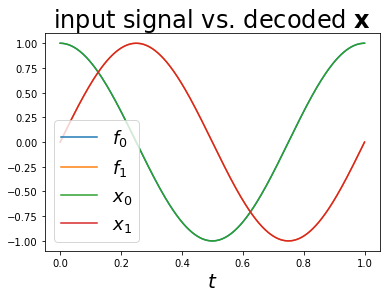

In [161]:
f = rates.dot(d)
plt.figure()
plt.plot(t, f[:, 0], label=r'$f_0$')
plt.plot(t, f[:, 1], label=r'$f_1$')
plt.plot(t, x[:, 0], label=r'$x_0$')
plt.plot(t, x[:, 1], label=r'$x_1$')
plt.legend(loc='lower left')
plt.xlabel(r'$t$')
plt.title('input signal vs. decoded $\mathbf{x}$');


### 1.3.3) Heterogeneity is important
Repeat 1.3.1 and 1.3.2 assuming that $\alpha=2$ and $J_{bias}=0$ for all neurons.

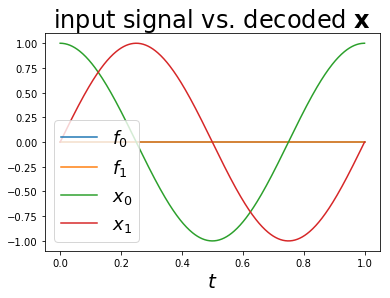

In [163]:
alpha=2.
J_bias=0.

rates = LIF_fun(J_bias*x.dot(e.T) + alpha)

x_train = np.linspace(-1, 1, 100) # train over this set of input signals 
x_train = np.array(np.meshgrid(x_train, x_train)).transpose((1,2,0)).reshape((-1, 2))
A = LIF_fun(J_bias*x_train.dot(e.T) + alpha)
d = np.linalg.pinv(A.T.dot(A)).dot(A.T).dot(x_train)

f = rates.dot(d)
plt.figure()
plt.plot(t, f[:, 0], label=r'$f_0$')
plt.plot(t, f[:, 1], label=r'$f_1$')
plt.plot(t, x[:, 0], label=r'$x_0$')
plt.plot(t, x[:, 1], label=r'$x_1$')
plt.legend(loc='lower left')
plt.xlabel(r'$t$')
plt.title('input signal vs. decoded $\mathbf{x}$');

By this point, you should understand the process of encoding and decoding a multidimensional signal in the firing rates of an ensemble of neurons. In finer detail, you should understand how the signal is converted to input currents for each neuron and how to find decode weights to reconstruct the signal from the nonlinear firing weights. The nengo library takes care of all of the encoding and decodings steps we implemented above automagically; we will be using nengo for the rest of the assignments.